In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from scipy import stats
import os
from ChemUtils import GlobalStandardScaler, EmscScaler
import random
from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt
from sys import stdout
from scipy.stats import f
from sklearn.model_selection import cross_val_predict
import obspy
from obspy.signal.detrend import polynomial
import seaborn as sns 
import scipy.io as sio
from scipy.signal import savgol_filter



In [3]:
# read in the data from the pickle file
with open('/root/autodl-tmp/vertigo/data/2_outlier_removal.pkl', 'rb') as f:
    df = pickle.load(f)

df

,UniqueFruitID,TestDate,Experiment,Cultivar,Fruit nr,Size,Weight,Brix,TA,Firmness (kg),...,11.75_GHz_imag,12.0_GHz_imag,12.25_GHz_imag,12.5_GHz_imag,12.75_GHz_imag,13.0_GHz_imag,13.25_GHz_imag,13.5_GHz_imag,13.75_GHz_imag,14.0_GHz_imag
0,1_Cult1_1,2024-01-18,1,Cult1,1,3.503926,303,14.0,0.7073,8.216365,...,0.303846,0.253675,0.189720,0.120293,0.059189,0.016484,-0.010067,-0.016946,-0.008702,0.009742
1,1_Cult1_10,2024-01-18,1,Cult1,10,3.425187,287,12.9,0.6510,8.336341,...,0.305021,0.248074,0.179614,0.109271,0.045785,0.002098,-0.023246,-0.029424,-0.019895,0.000753
2,1_Cult1_100,2024-01-18,1,Cult1,100,3.562981,297,13.8,0.5634,8.421389,...,0.298692,0.245326,0.179319,0.109267,0.046721,0.004244,-0.018550,-0.021822,-0.010473,0.012072
3,1_Cult1_11,2024-01-18,1,Cult1,11,3.208652,190,12.4,0.6625,7.756196,...,0.311484,0.256747,0.188344,0.114988,0.050124,0.004789,-0.021089,-0.028441,-0.020170,0.000686
4,1_Cult1_12,2024-01-18,1,Cult1,12,2.834637,190,12.3,0.4652,8.031300,...,0.314446,0.255215,0.185936,0.113476,0.048196,0.001833,-0.026797,-0.036994,-0.030069,-0.008056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432,5_Cult2_95,2024-03-20,5,Cult2,95,3.385817,235,13.4,0.5216,7.061293,...,0.326096,0.281670,0.219614,0.148329,0.080791,0.030043,0.001433,-0.005997,0.004771,0.024163
2433,5_Cult2_96,2024-03-20,5,Cult2,96,2.755897,95,13.1,0.4091,6.761242,...,-0.003478,0.057510,0.108142,0.150137,0.187229,0.225474,0.263218,0.304818,0.347171,0.388783
2434,5_Cult2_97,2024-03-20,5,Cult2,97,2.677157,106,13.5,0.6321,8.611444,...,0.321611,0.276308,0.212152,0.137770,0.066491,0.013561,-0.015859,-0.023929,-0.012627,0.009931
2435,5_Cult2_98,2024-03-20,5,Cult2,98,2.854322,113,14.0,0.5719,6.986224,...,0.308256,0.255912,0.187893,0.112782,0.043732,-0.007284,-0.036126,-0.041328,-0.026887,-0.000309


In [13]:
# Separate spectral data and quality attributes
spectral_cols = [col for col in df.columns if 'GHz' in col]
quality_attrs = ['Brix', 'TA', 'Firmness (kg)']

X = df[spectral_cols]
y = df[quality_attrs]
y_brix = df['Brix'].values


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_brix, test_size=0.2, random_state=42, shuffle=True
)



In [14]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.fit_transform(X_test)

In [15]:
## Define a function to perform Standard Normal Variate on all spectra  
def snv(input_data):
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i, :] = (input_data[i, :] - np.mean(input_data[i, :])) / np.std(input_data[i, :])
    return data_snv

## Define a function detrend all spectra
def det(input_data):
    data_det = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply detrend
        data_det[i, :] = polynomial(input_data.iloc[i, :].values.copy(), order=2, plot=False)
    return data_det

x_train_prep = snv(det(X_train)) # apply SNV to detrended signal 
x_test_prep = snv(det(X_test))

In [16]:
xscaler = GlobalStandardScaler(normfact=2) # normfact=2 ensure that we are dividing by 2. std 

## We use the avalaible data from the training set to create the scaler, and use that 
## same scaler to scale the other (unseen) sets
x_train_gs = xscaler.fit_transform(X_train)
x_test_gs = xscaler.transform(X_test)

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, KFold

preprocessing_methods = {
    'Raw': None,
    'SNV': snv,  # Using the SNV function defined previously
    'standardize': lambda x: StandardScaler().fit_transform(x),
    'SG': lambda x: savgol_filter(x, window_length=11, polyorder=2, deriv=1),
    'SNV+SG': lambda x: savgol_filter(snv(x), window_length=11, polyorder=2, deriv=1),
}

In [37]:
def evaluate_preprocessing(X, y, method_name, method_func, target_var):
    """Evaluate preprocessing method for one target variable"""
    # Apply preprocessing
    X_processed = method_func(X) if method_func else X
    
    # PLS model - start with 10 components (can be tuned)
    pls = PLSRegression(n_components=20)
    
    # 5-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pls, X_processed, y[target_var], 
                           cv=kfold, scoring='r2')
    
    # Calculate RMSE
    rmse_scores = np.sqrt(-cross_val_score(pls, X_processed, y[target_var],
                            cv=kfold, scoring='neg_mean_squared_error'))
    
    return {
        'Method': method_name,
        'Target': target_var,
        'R2_mean': np.mean(scores),
        'R2_std': np.std(scores),
        'RMSE_mean': np.mean(rmse_scores),
        'RMSE_std': np.std(rmse_scores)
    }

In [38]:
import pandas as pd

results = []
target_vars = ['Brix', 'TA', 'Firmness (kg)']

for method_name, method_func in preprocessing_methods.items():
    for target in target_vars:
        res = evaluate_preprocessing(X.values, y, method_name, method_func, target)
        results.append(res)

results_df = pd.DataFrame(results)

In [39]:
results_df

,Method,Target,R2_mean,R2_std,RMSE_mean,RMSE_std
0,Raw,Brix,0.228850,0.072146,0.630642,0.027302
1,Raw,TA,0.560961,0.054740,0.097026,0.005685
2,Raw,Firmness (kg),0.518022,0.046115,0.921860,0.037498
3,SNV,Brix,0.204886,0.095012,0.639823,0.033760
4,SNV,TA,0.486975,0.092620,0.104640,0.008778
5,SNV,Firmness (kg),0.426808,0.072970,1.004451,0.055379
6,standardize,Brix,0.228850,0.072146,0.630642,0.027302
7,standardize,TA,0.560961,0.054740,0.097026,0.005685
8,standardize,Firmness (kg),0.518022,0.046115,0.921860,0.037498
9,SG,Brix,0.205029,0.099140,0.639763,0.036020


In [40]:
# Rank methods by R² score for each target
ranked_results = results_df.groupby('Target').apply(
    lambda x: x.sort_values('R2_mean', ascending=False)
).reset_index(drop=True)
print(f"\n=== Rank methods by R² score for each target ===")
# Display top 3 methods per target
for target in target_vars:
    print(f"\n=== Best methods for {target} ===")
    print(ranked_results[ranked_results['Target'] == target].head(3))


=== Rank methods by R² score for each target ===

=== Best methods for Brix ===
        Method Target   R2_mean    R2_std  RMSE_mean  RMSE_std
0  standardize   Brix  0.228850  0.072146   0.630642  0.027302
1          Raw   Brix  0.228850  0.072146   0.630642  0.027302
2           SG   Brix  0.205029  0.099140   0.639763  0.036020

=== Best methods for TA ===
         Method Target   R2_mean    R2_std  RMSE_mean  RMSE_std
10  standardize     TA  0.560961  0.054740   0.097026  0.005685
11          Raw     TA  0.560961  0.054740   0.097026  0.005685
12           SG     TA  0.536250  0.070705   0.099604  0.006666

=== Best methods for Firmness (kg) ===
        Method         Target   R2_mean    R2_std  RMSE_mean  RMSE_std
5          Raw  Firmness (kg)  0.518022  0.046115   0.921860  0.037498
6  standardize  Firmness (kg)  0.518022  0.046115   0.921860  0.037498
7           SG  Firmness (kg)  0.473176  0.079961   0.962106  0.063515


/var/folders/20/z1yv0ngn7f1f96zqhdbcd3w00000gn/T/ipykernel_56388/2744881905.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ranked_results = results_df.groupby('Target').apply(


In [41]:
# Rank methods by RMSE_mean score for each target
ranked_results = results_df.groupby('Target').apply(
    lambda x: x.sort_values('RMSE_mean', ascending=True)
).reset_index(drop=True)
print(f"\n=== Rank methods by RMSE_mean score for each target ===")
# Display top 3 methods per target
for target in target_vars:
    print(f"\n=== Best methods for {target} ===")
    print(ranked_results[ranked_results['Target'] == target].head(3))


=== Rank methods by RMSE_mean score for each target ===

=== Best methods for Brix ===
        Method Target   R2_mean    R2_std  RMSE_mean  RMSE_std
0  standardize   Brix  0.228850  0.072146   0.630642  0.027302
1          Raw   Brix  0.228850  0.072146   0.630642  0.027302
2           SG   Brix  0.205029  0.099140   0.639763  0.036020

=== Best methods for TA ===
         Method Target   R2_mean    R2_std  RMSE_mean  RMSE_std
10  standardize     TA  0.560961  0.054740   0.097026  0.005685
11          Raw     TA  0.560961  0.054740   0.097026  0.005685
12           SG     TA  0.536250  0.070705   0.099604  0.006666

=== Best methods for Firmness (kg) ===
        Method         Target   R2_mean    R2_std  RMSE_mean  RMSE_std
5          Raw  Firmness (kg)  0.518022  0.046115   0.921860  0.037498
6  standardize  Firmness (kg)  0.518022  0.046115   0.921860  0.037498
7           SG  Firmness (kg)  0.473176  0.079961   0.962106  0.063515


/var/folders/20/z1yv0ngn7f1f96zqhdbcd3w00000gn/T/ipykernel_56388/1104699602.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ranked_results = results_df.groupby('Target').apply(


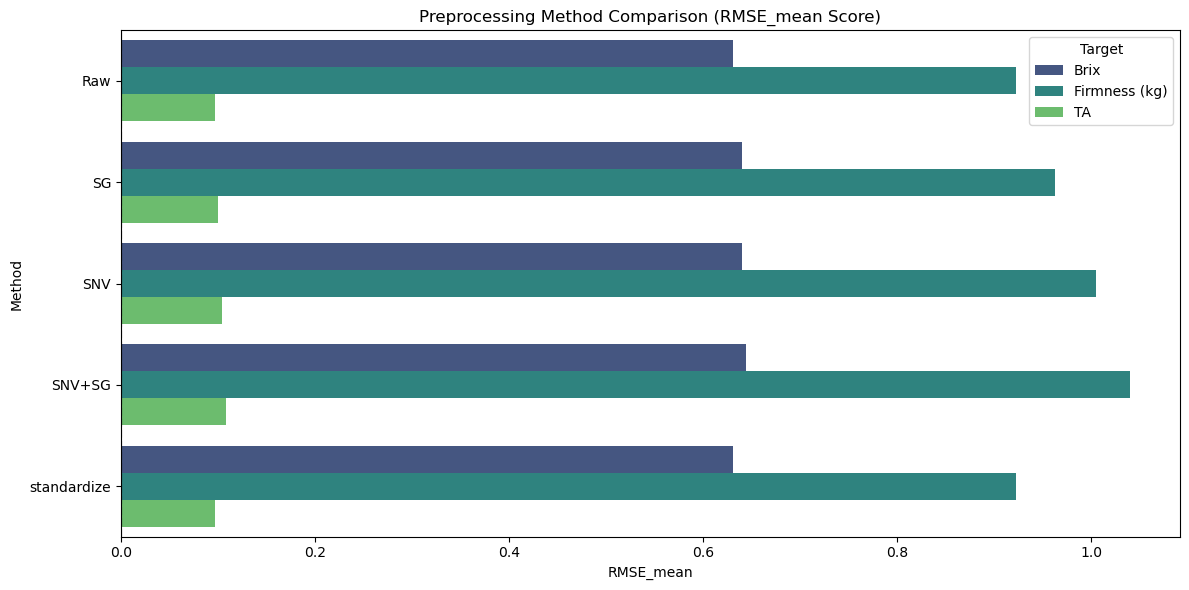

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aggregate data to align xerr with x
aggregated_results = results_df.groupby(['Method', 'Target']).agg(
    RMSE_mean=('RMSE_mean', 'mean')
).reset_index()

# # Ensure xerr matches the aggregated data
# aggregated_results['xerr'] = aggregated_results['R2_std']

# Plot the barplot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=aggregated_results,
    x='RMSE_mean',
    y='Method',
    hue='Target',
    palette='viridis',
    errorbar=None  # Disable automatic error bars
)

plt.title('Preprocessing Method Comparison (RMSE_mean Score)')
plt.axvline(0, color='k', linestyle='--')
plt.tight_layout()
plt.show()

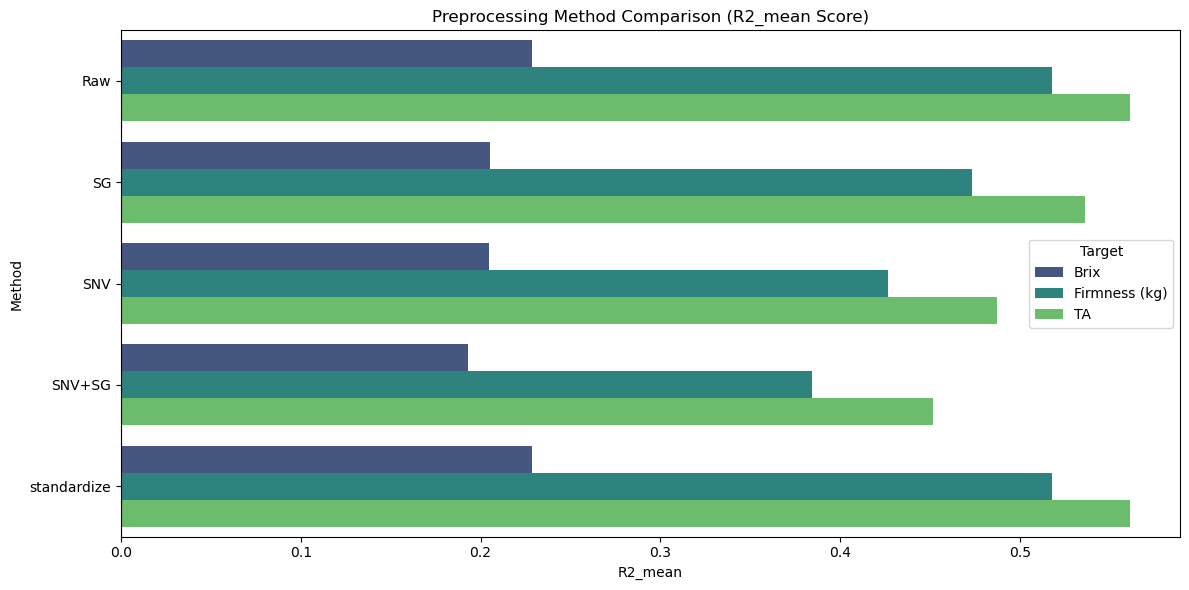

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aggregate data to align xerr with x
aggregated_results = results_df.groupby(['Method', 'Target']).agg(
    R2_mean=('R2_mean', 'mean')
).reset_index()

# # Ensure xerr matches the aggregated data
# aggregated_results['xerr'] = aggregated_results['R2_std']

# Plot the barplot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=aggregated_results,
    x='R2_mean',
    y='Method',
    hue='Target',
    palette='viridis',
    errorbar=None  # Disable automatic error bars
)

plt.title('Preprocessing Method Comparison (R2_mean Score)')
plt.axvline(0, color='k', linestyle='--')
plt.tight_layout()
plt.show()

I'll perform standardize. 

In [179]:
## Define the Huber distance (source DeepChemometrics)
def huber(y_true, y_pred, delta=1.0):
    # Ensure inputs are NumPy arrays
    y_true = np.array(y_true).reshape(-1, 1)
    y_pred = np.array(y_pred).reshape(-1, 1)
    return np.mean(delta**2 * ((1 + ((y_true - y_pred) / delta)**2)**0.5 - 1))

## Create a huber loss scorer for cross_val_score()
huber_score=make_scorer(huber)

## Function to help find the best number of components of the PLS based on 10 CV Huber Loss
def pls_optimization(X, Y, plot_components=False):
    """
    This function finds the optimal number of PLS components (up to 40) that best models the data
    based on huber loss and 10 CV
    X - The training data X
    Y - The training data Y
    plot_components - Plot the model's optimization and optimized model
    """
    #Run PLS including a variable number of components, up to 40,  and calculate mean of 10 CV huber loss
    cv_huber=[]
    component = np.arange(1, 40)
    for i in component:
        pls = PLSRegression(n_components=i)
        cv_score=cross_val_score(pls, X, Y, cv=KFold(10, shuffle = True),\
                        n_jobs=-1, scoring=huber_score)
        cv_huber.append(np.mean(cv_score))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum
    cv_hubermin = np.argmin(cv_huber)
    print("Suggested number of components based in Mean of 10 CV huber loss: ", cv_hubermin+1)
    print('Minimum found in Mean of 10 CV huber loss: {}'.format(np.min(cv_huber)))
    stdout.write("\n")
 
    # Define PLS with suggested number of components and fit train data
    pls = PLSRegression(n_components=cv_hubermin+1)
    pls.fit(X, Y)
    
    # Get predictions for calibration(train) and validation(test) sets
    Y_pred = pls.predict(X) 
    
    # Calculate and print scores for validation set
    R2_p = r2_score(Y, Y_pred)
    mse_p = mean_squared_error(Y, Y_pred)
    hub_p = huber(Y, Y_pred)
    sep = np.std(Y_pred-Y)
    rmse_p = np.sqrt(mse_p)
    
    print('\nError metrics for test set:')
    print('R2: %5.3f'  % R2_p)
    print('Root Mean Squared Error (RMSE): %5.3f' % rmse_p)
    print('Huber loss (huber): %5.3f' % hub_p)
    print('Standard Error Prediction (SEP): %5.3f' % sep)
 
    # Plot regression and PLS LV search
    rangey = max(Y) - min(Y)
    rangex = max(Y_pred) - min(Y_pred)
 
    if plot_components is True:
        plt.figure(figsize=(15,5))
        ax1=plt.subplot(1,2,1)
        ax1.plot(component, np.array(cv_huber), '-v', color = 'blue', mfc='blue')
        ax1.plot(component[cv_hubermin], np.array(cv_huber)[cv_hubermin], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS components')
        plt.ylabel('Mean od 10 CV Huber loss')
        plt.title('# PLS components')
        plt.xlim(left=-1)

        z = np.polyfit(np.ravel(Y), np.ravel(Y_pred), 1)        
        ax2 = plt.subplot(1,2,2, aspect=1)
        ax2.scatter(Y,Y_pred,c='k',s=2)
        ax2.plot(Y, z[1]+z[0]*Y, c='blue', linewidth=2,label='linear fit')
        ax2.plot(Y, Y, color='orange', linewidth=1.5, label='y=x')
        plt.ylabel('Predicted')
        plt.xlabel('Measured')
        plt.title('Prediction from PLS')
        plt.legend(loc=4)
 
        # Print the scores on the plot
        plt.text(min(Y_pred)+0.02*rangex, max(Y)-0.1*rangey, 'R$^{2}=$ %5.3f'  % R2_p)
        plt.text(min(Y_pred)+0.02*rangex, max(Y)-0.15*rangey, 'RMSE: %5.3f' % rmse_p)
        plt.text(min(Y_pred)+0.02*rangex, max(Y)-0.2*rangey, 'Huber loss: %5.3f' % hub_p)
        plt.show()    
    return 

    
## Function to help find the best number of components of the PLS based in the MSE or Huber Loss
def pls_prediction(X_calib, Y_calib, X_valid, Y_valid, components, plot_components=False):
    """
    Very similar to the previous function but without the CV optimization part.
    This function is simply used to compute the PLS model on train data and the error metrics on both
    train and test data. 
    NOTE: Check if the Y data is in its original scale before interpreting the error metrics.
    """
    i=components
    pls = PLSRegression(n_components=i)
    ## Fit PLS model to train/calib data
    pls.fit(X_calib, Y_calib)
    ## Predict test/validation data
    Y_valid_pred = pls.predict(X_valid)
    ## Predict train/calibration data (for metric purposes)
    Y_calib_pred = pls.predict(X_calib)
         
    ## Compute test error scores
    score_p = r2_score(Y_valid, Y_valid_pred)
    mse_p = mean_squared_error(Y_valid, Y_valid_pred)
    rmse_p = np.sqrt(mse_p)
    sep = np.std(Y_valid-Y_valid_pred)
    
    ## Compute train error scores 
    score_p0 = r2_score(Y_calib, Y_calib_pred)
    mse_p0 = mean_squared_error(Y_calib, Y_calib_pred)
    rmse_p0 = np.sqrt(mse_p0)
    sep0 = np.std(Y_calib-Y_calib_pred)
  
    print('ERROR METRICS: \t TRAIN \t\t TEST')
    print('--------------------------------------')
    print('R2: \t\t %5.3f \t\t %5.3f'  % (score_p0, score_p ))
#    print('Mean Squared Error (MSE): %5.3f' % mse_p)
    print('RMSE: \t\t %5.3f \t\t %5.3f' % (rmse_p0, rmse_p))
    print('SEP : \t\t %5.3f \t\t %5.3f' % (sep0, sep))
 
    ## Plot regression for PLS predicted data
    rangey = max(Y_valid) - min(Y_valid)
    rangex = max(Y_valid_pred) - min(Y_valid_pred)

    if plot_components is True:
        plt.figure(figsize=(8,8))
        z = np.polyfit(np.ravel(Y_valid), np.ravel(Y_valid_pred), 1)
        ax = plt.subplot(aspect=1)
        ax.scatter(Y_valid,Y_valid_pred,c='k',marker='o',s=20, alpha=0.6)
        ax.plot(Y_valid, z[1]+z[0]*Y_valid, c='blue', linewidth=2,label='linear fit')
        ax.plot(Y_valid, Y_valid, 'k--', linewidth=1.5, label='y=x')
        plt.ylabel('Predicted')
        plt.xlabel('Measured')
        plt.title('Prediction from PLS')
        plt.legend(loc=4)
 
        # Print the scores on the plot
        plt.text(min(Y_valid_pred)+0.02*rangex, max(Y_valid)-0.1*rangey, 'R$^{2}=$ %5.3f'  % score_p)
        plt.text(min(Y_valid_pred)+0.02*rangex, max(Y_valid)-0.15*rangey, 'RMSE: %5.3f' % rmse_p)
        plt.text(min(Y_valid_pred)+0.02*rangex, max(Y_valid)-0.2*rangey, 'SEP: %5.3f' % sep)
        plt.show() 
        
    return

** Calibrate PLS on Raw data
100% completed
Suggested number of components based in Mean of 10 CV huber loss:  21
Minimum found in Mean of 10 CV huber loss: 0.16247977308796133


Error metrics for test set:
R2: 0.313
Root Mean Squared Error (RMSE): 0.595
Huber loss (huber): 0.150
Standard Error Prediction (SEP): 0.595


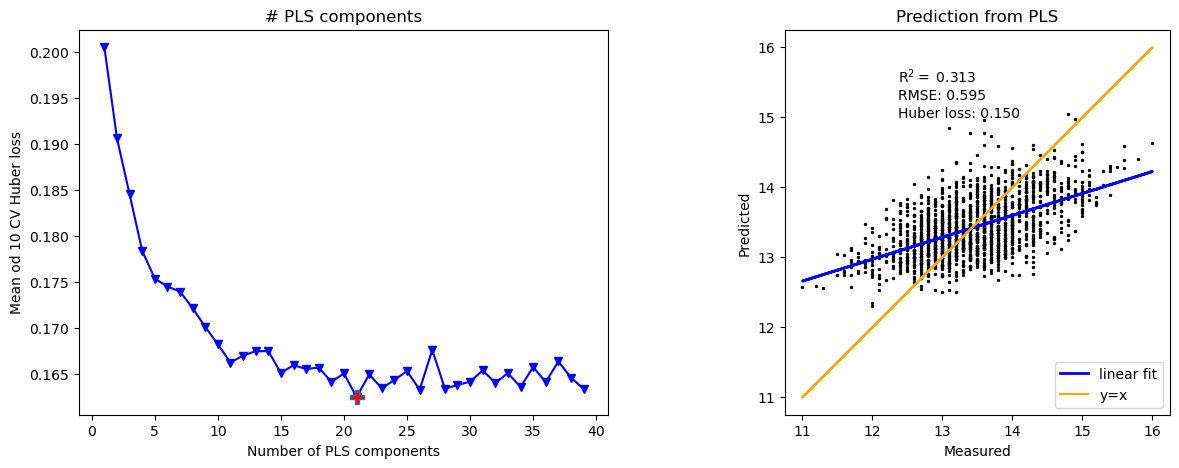

In [180]:
# Run PLS prediction for a specific target variable
print('** Calibrate PLS on Raw data')
pls_optimization(X_train, y_train,plot_components=True)

** Calibrate PLS on Standardized data **
100% completed
Suggested number of components based in Mean of 10 CV huber loss:  38
Minimum found in Mean of 10 CV huber loss: 0.16278305169860988


Error metrics for test set:
R2: 0.340
Root Mean Squared Error (RMSE): 0.583
Huber loss (huber): 0.144
Standard Error Prediction (SEP): 0.583


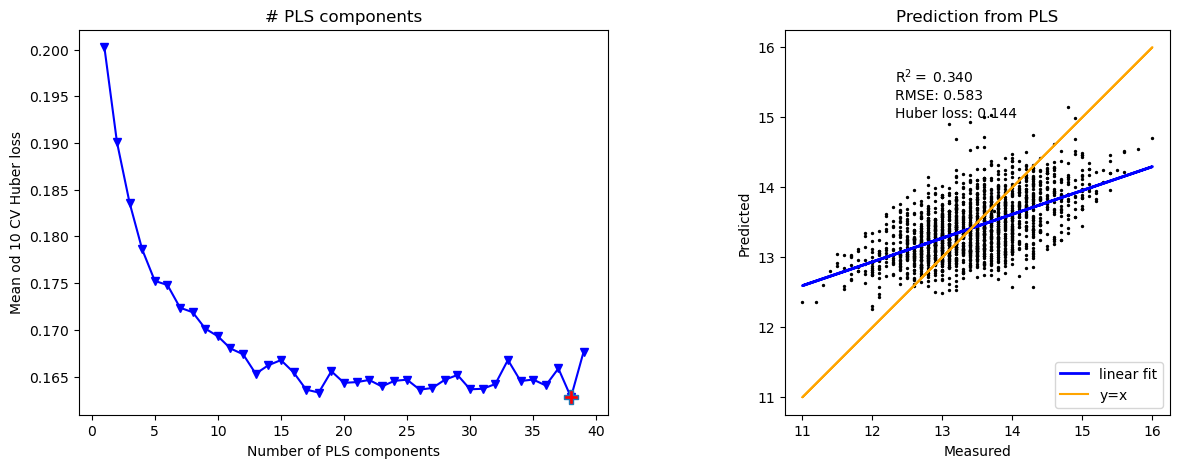

In [181]:
# Run PLS prediction for a specific target variable
print('** Calibrate PLS on Standardized data **')
pls_optimization(x_train_scaled, y_train,plot_components=True)

** Calibrate PLS on Prep data
100% completed
Suggested number of components based in Mean of 10 CV huber loss:  33
Minimum found in Mean of 10 CV huber loss: 0.16502931253692613


Error metrics for test set:
R2: 0.325
Root Mean Squared Error (RMSE): 0.590
Huber loss (huber): 0.147
Standard Error Prediction (SEP): 0.590


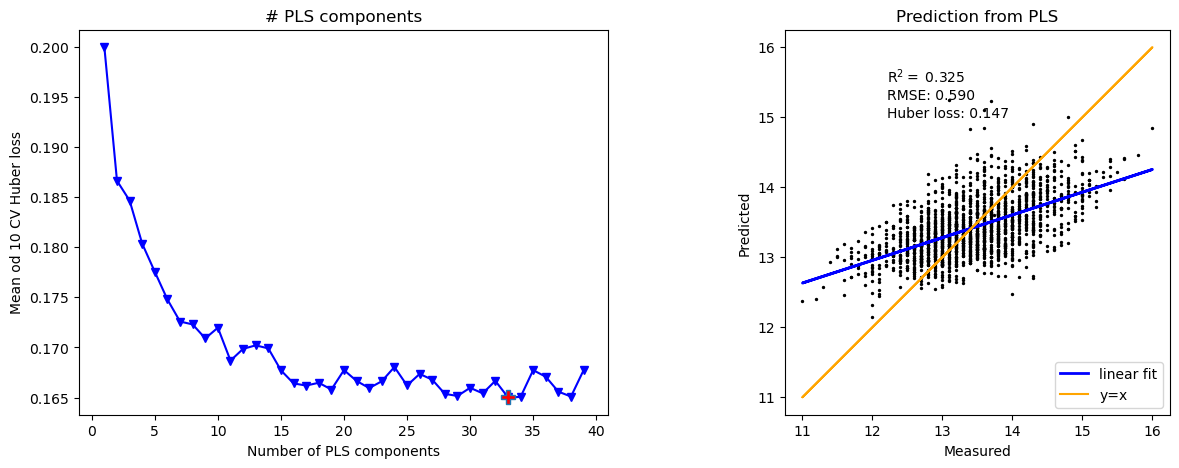

In [182]:
print('** Calibrate PLS on Prep data')
pls_optimization(x_train_prep, y_train,plot_components=True)


** Calibrate PLS on GS data
100% completed
Suggested number of components based in Mean of 10 CV huber loss:  21
Minimum found in Mean of 10 CV huber loss: 0.16270724083141247


Error metrics for test set:
R2: 0.313
Root Mean Squared Error (RMSE): 0.595
Huber loss (huber): 0.150
Standard Error Prediction (SEP): 0.595


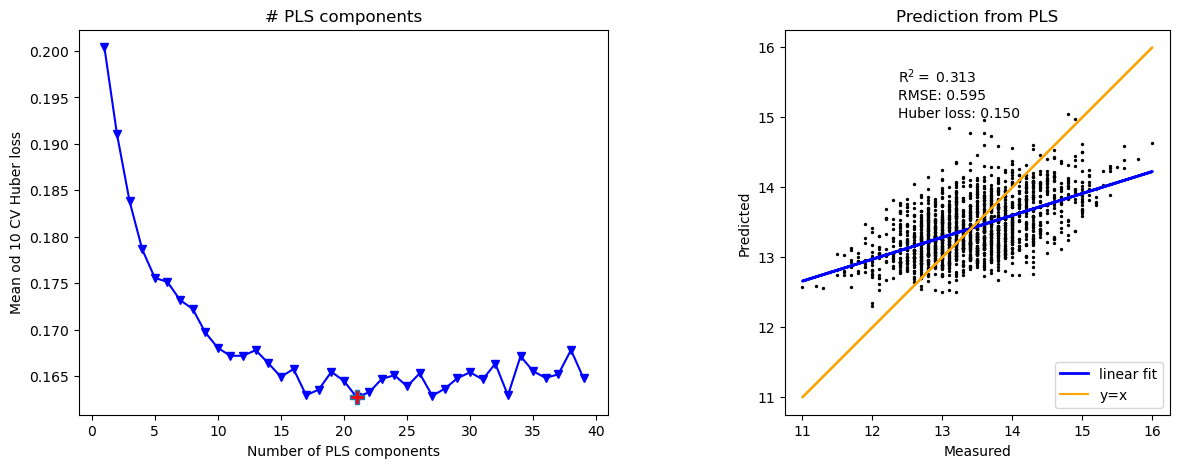

In [183]:
print('** Calibrate PLS on GS data')
pls_optimization(x_train_gs, y_train,plot_components=True)

Optimal PLS model applyed to full dataset

ERROR METRICS: 	 TRAIN 		 TEST
--------------------------------------
R2: 		 0.322 		 0.298
RMSE: 		 0.591 		 0.609
SEP : 		 0.591 		 0.608


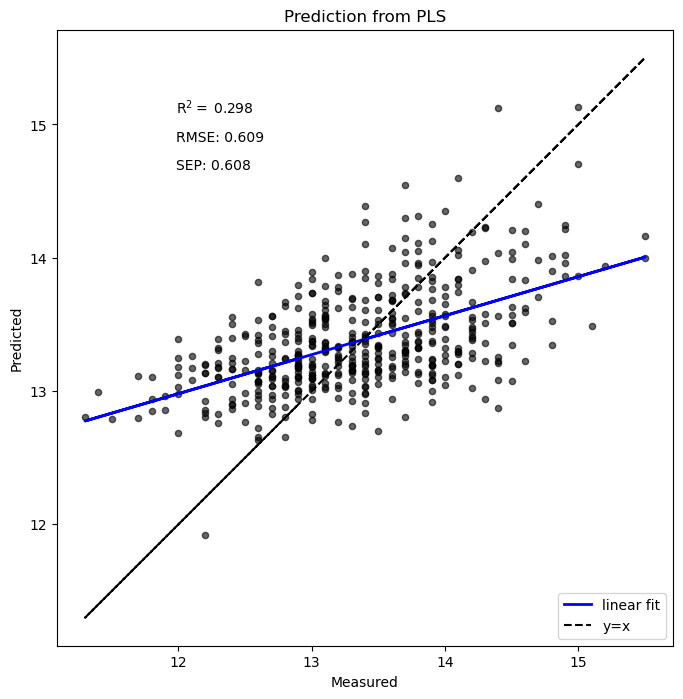

In [184]:
print('Optimal PLS model applyed to full dataset\n')    
pls_prediction(x_train_prep,y_train, x_test_prep , y_test, components=31, plot_components=True) 

Optimal PLS model applyed to full dataset

ERROR METRICS: 	 TRAIN 		 TEST
--------------------------------------
R2: 		 0.340 		 -0.385
RMSE: 		 0.583 		 0.855
SEP : 		 0.583 		 0.853


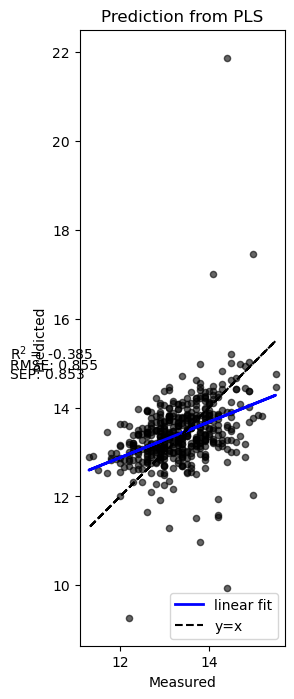

In [188]:
print('Optimal PLS model applyed to full dataset\n')    
pls_prediction(x_train_scaled, y_train, x_test_scaled , y_test, components=38, plot_components=True) 

Optimal PLS model applyed to full dataset

ERROR METRICS: 	 TRAIN 		 TEST
--------------------------------------
R2: 		 0.313 		 0.299
RMSE: 		 0.595 		 0.609
SEP : 		 0.595 		 0.608


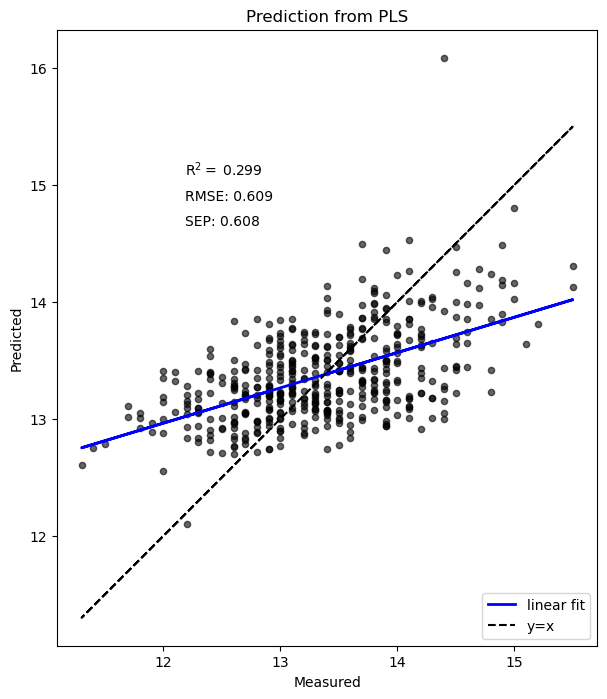

In [189]:
print('Optimal PLS model applyed to full dataset\n')    
pls_prediction(X_train, y_train, X_test , y_test, components=21, plot_components=True) 

Optimal PLS model applyed to full dataset

ERROR METRICS: 	 TRAIN 		 TEST
--------------------------------------
R2: 		 0.324 		 0.291
RMSE: 		 0.590 		 0.612
SEP : 		 0.590 		 0.611


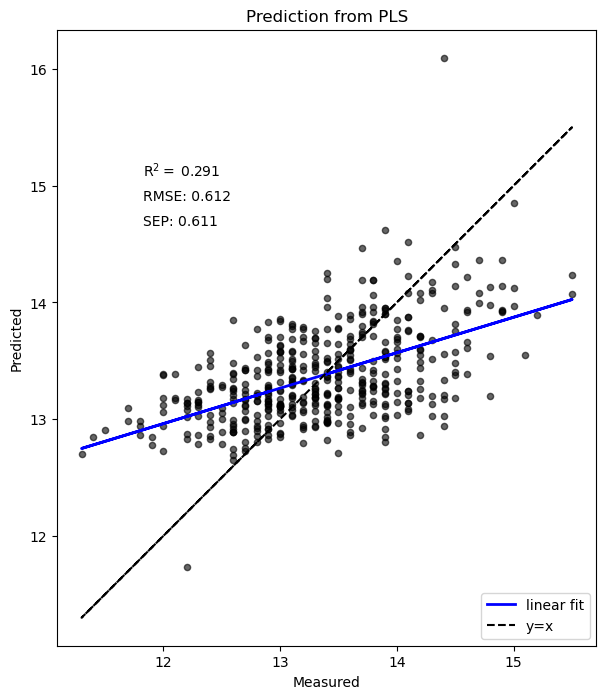

In [187]:
print('Optimal PLS model applyed to full dataset\n')    
pls_prediction(x_train_gs, y_train, x_test_gs , y_test, components=27, plot_components=True) 

# Explore correlations among targets

Examine correlations between Brix, TA, and Firmness. If they're highly correlated, a multi-output approach may capture shared patterns. If weakly correlated, separate models may be better.

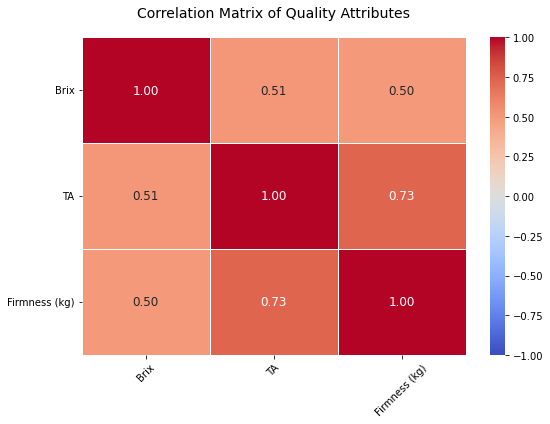

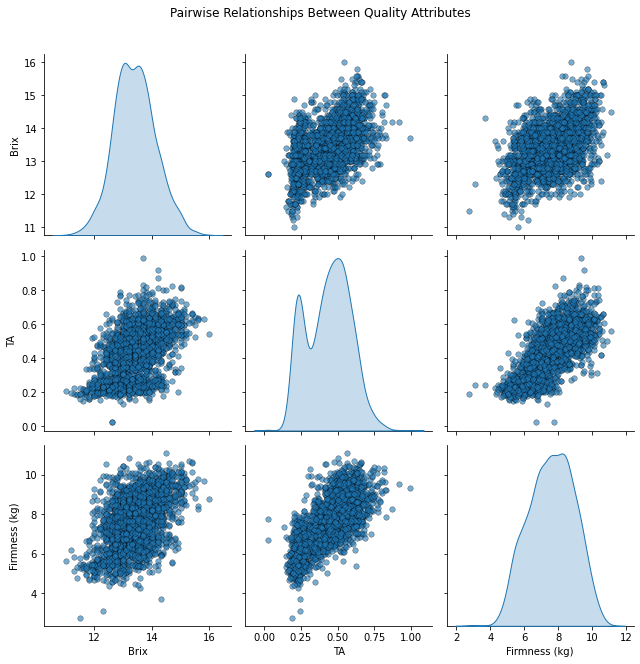


Correlation Coefficients:
                   Brix        TA  Firmness (kg)
Brix           1.000000  0.511178       0.495045
TA             0.511178  1.000000       0.733572
Firmness (kg)  0.495045  0.733572       1.000000


In [5]:
targets = df[['Brix', 'TA', 'Firmness (kg)']]

# Calculate correlation matrix
corr_matrix = targets.corr(method='pearson')  # Pearson is default but being explicit

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            linewidths=0.5, 
            fmt=".2f",
            annot_kws={"size": 12})
plt.title('Correlation Matrix of Quality Attributes', pad=20, fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Pairplot for additional visualization
sns.pairplot(targets, 
             diag_kind='kde', 
             plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k'},
             height=3)
plt.suptitle('Pairwise Relationships Between Quality Attributes', y=1.02)
plt.tight_layout()
plt.show()

# Print numerical correlation values
print("\nCorrelation Coefficients:")
print(corr_matrix)

- TA vs. Firmness: Strong positive correlation (0.73)

    Fruits with higher acidity (TA) are significantly more likely to be firm. This strong correlation suggests that TA and Firmness may share underlying spectral patterns in your microwave reflection data.

- Brix is moderately correlated with both but may still have unique spectral relationships.

- Multi-output modeling could be advantageous for TA and Firmness, while Brix might benefit from a separate model.